In [65]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd

from names_dataset import NameDataset, NameWrapper

In [66]:
# 27.12.2023 notes:
# downloaded the raw data, it's in the "XX" first two letters format, need to collect a diverse dataset from it (10gig), random sample 1 percent
# that's it

In [128]:
ir_names = pd.read_csv("./../name_dataset/data/IR.csv", header = None)
ir_names.columns = ["first_name", "second_name", "gender", "geo"]
ir_names = ir_names[~ir_names["first_name"].isna()]
unique_ir_names = ir_names[ir_names["first_name"].str.contains('^[a-zA-Z]+$')]["first_name"].unique()
names = [' ' + name for name in unique_ir_names]

In [130]:
names_lengths = np.array([len(name) for name in names])

max length: 26


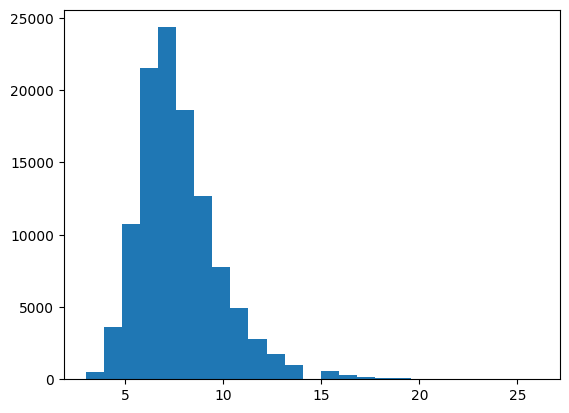

In [131]:
MAX_LENGTH = unique_ir_names_lengths.max()
print("max length:", MAX_LENGTH)
plt.hist(unique_ir_names_lengths, bins = 25)
plt.show()

In [179]:
tokens = set()

for name in names:
    tokens.update(set(name))

tokens.update(' ')
tokens = list(tokens)

In [180]:
token_to_id = {token:index for index, token in enumerate(tokens)}

In [181]:
def to_matrix(names, max_len=None, pad=token_to_id[' '], dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""

    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        line_ix = [token_to_id[c] for c in names[i]]
        names_ix[i, :len(line_ix)] = line_ix

    if not batch_first: # convert (batch, time) into (time, batch)
        names_ix = np.transpose(names_ix)

    return names_ix

In [182]:
to_matrix(names[:10])

array([[36, 34, 42, 21,  5, 36, 36, 36, 36, 36],
       [36, 39,  7,  5, 17, 22, 12, 42, 28, 42],
       [36, 13,  5,  4, 27,  5, 36, 36, 36, 36],
       [36, 48,  1,  5, 16, 21, 45, 27, 36, 36],
       [36, 47, 45, 52,  2, 16,  1,  5,  6, 36],
       [36, 34, 42, 21, 52, 36, 36, 36, 36, 36],
       [36, 18,  5, 40, 42, 27, 36, 36, 36, 36],
       [36, 33, 42, 52, 42, 17, 27,  5, 36, 36],
       [36, 15,  5,  6, 45, 40, 36, 36, 36, 36],
       [36,  8, 42,  4, 27,  5, 36, 36, 36, 36]])

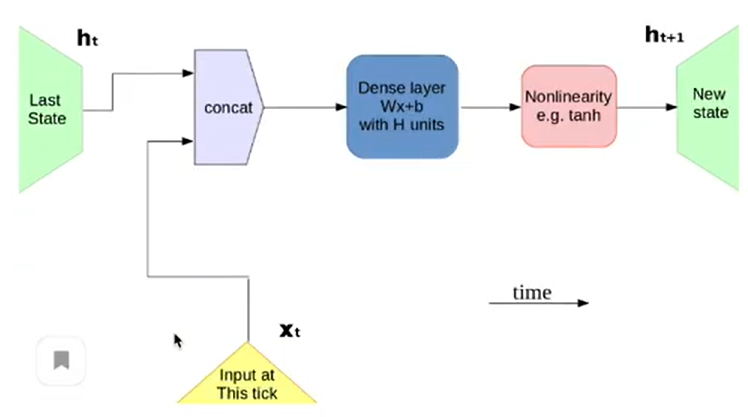

In [183]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [184]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
    
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat([x_emb, h_prev], dim=1)
        h_next = self.rnn_update(x_and_h)
        
        h_next = torch.tanh(h_next)
        
        assert h_next.size() == h_prev.size()

        logits = self.rnn_to_logits(h_next)

        return h_next, F.log_softmax(logits, -1)

    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [185]:
char_rnn = CharRNNCell()
criterion = nn.NLLLoss()

In [186]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = char_rnn(x_t, hid_state) # <-- here we call your one-step code
        logprobs.append(logp_next)

    return torch.stack(logprobs, dim=1)


In [188]:
batch_ix = to_matrix(names[:5])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logp_seq = rnn_loop(char_rnn, batch_ix)
num_tokens=len(tokens)
assert torch.max(logp_seq).data.numpy() <= 0
assert tuple(logp_seq.size()) == batch_ix.shape + (num_tokens,)


In [189]:
predictions_logp = logp_seq[:, :-1]
actual_next_tokens = batch_ix[:, 1:]

# .contiguous() method checks that tensor is stored in the memory correctly to
# get its view of desired shape.
loss = criterion(predictions_logp.contiguous().view(-1, num_tokens),
                 actual_next_tokens.contiguous().view(-1))

loss.backward()

for w in char_rnn.parameters():
    assert w.grad is not None and torch.max(torch.abs(w.grad)).data.numpy() != 0, \
    "Loss is not differentiable w.r.t. a weight with shape %s. Check forward method." % (w.size(),)

In [190]:
from IPython.display import clear_output
from random import sample

char_rnn = CharRNNCell()
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

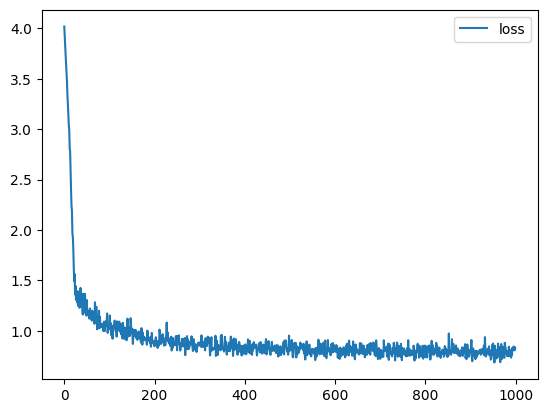

In [191]:
MAX_LENGTH = 26

for i in range(1000):
    batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]
    
    loss = criterion(predictions_logp.contiguous().view(-1, num_tokens),
                 actual_next_tokens.contiguous().view(-1))
    
    # train with backprop
    # YOUR CODE HERE
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i+1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."


In [192]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    """
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling. higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    """

    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)

    # feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)

    # start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [193]:
for _ in range(10):
    print(generate_sample(char_rnn))

 Linncku                  
 Nadbmlgo                 
 Doiudstllee              
 Noshabd                  
 Saudimazet               
 Tarih                    
 Povnaf                   
 Maz E                    
 Ayoma                    
 Ahmmokoaztb              


In [196]:
for _ in range(50):
    print(generate_sample(char_rnn, seed_phrase=' Jaw'))

 Jawghkban                
 Jawmaro                  
 Jawbfoda                 
 Jawcer                   
 Jawmas                   
 Jawbfl                   
 Jawtombhabishehzor       
 Jawset                   
 Jawt                     
 Jawidem                  
 Jawirnyo                 
 Jawkevruk                
 Jawbdn                   
 Jawtu                    
 Jawask                   
 Jawuk                    
 Jawmcus                  
 Jawvtote                 
 Jaw                      
 Jawrr                    
 JawDnam                  
 Jawh                     
 Jaw                      
 Jawromos                 
 Jawsmidkandok            
 Jawaalooa                
 Jawdgieda                
 Jawdushazomek            
 Jawbe                    
 Jawre                    
 Jawzahte                 
 Jawa                     
 Jawdma                   
 Jaw                      
 JawslLe                  
 Jawiar                   
 Jawyot                   
 